<a href="https://colab.research.google.com/github/gustasvs/finger_count_detection/blob/main/reformatted%20to%20run%20with%20google%20collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
load_not_train = True

# hparams
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.01

# image params
# image_size = 96 # [96, 128, 160, 192, 224]
image_size = 42
gray_scale = True

In [49]:
# imports
import numpy as np
import os
import sys
import random

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
!pip install tensorflow_addons
from tensorflow_addons.metrics import F1Score

from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode




In [18]:

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

def flip_images(images):
    flipped_images = []
    for img in images:
        flipped_images.append(img)
        flipped_images.append(tf.image.flip_left_right(img))
        flipped_images.append(tf.image.flip_up_down(img))
        flipped_images.append(tf.image.flip_left_right(tf.image.flip_up_down(img)))
    return flipped_images

def scale_images(images):
    scaled_images = []
    scaling_factors = [1, 1.1, 1.2]
    for img in images:
        original_size = tf.shape(img)[:2]
        for factor in scaling_factors:
            new_size = tf.cast(tf.round(tf.cast(original_size, tf.float32) * factor), tf.int32)
            scaled_img = tf.image.resize(img, new_size)
            scaled_img = tf.image.resize_with_crop_or_pad(scaled_img, original_size[0], original_size[1])
            scaled_images.append(scaled_img)
    return scaled_images

def color_jitter_images(images):
    color_jittered_images = []
    for img in images:
        for _ in range(3):
            color_jittered_img = tf.image.random_brightness(img, max_delta=0.2)
            color_jittered_img = tf.image.random_contrast(color_jittered_img, lower=0.8, upper=1.2)
            color_jittered_images.append(color_jittered_img)
    return color_jittered_images


def rotate_images(images):
    rotated_images = []
    for img in images:
        rotated_images.append(img)
        # rotated_images.append(tf.image.rot90(img, k=1))
        # rotated_images.append(tf.image.rot90(img, k=3))
    return rotated_images

def preprocess_image(img, target_size=(700, 700), gray_scale=False, single=False):
    original_shape = tf.cast(tf.shape(img)[:2], tf.float32)
    min_edge = tf.reduce_min(original_shape)
    # fix to counter rounding being unprecise
    scale_factor = target_size[0] * 1.001 / min_edge
    new_shape = tf.cast(tf.round(original_shape * scale_factor), tf.int32)
    img = tf.image.resize(img, new_shape)
    if gray_scale:
        img = tf.image.rgb_to_grayscale(img)
    img = img / 255.0

    # handle case when we need to return single image
    if single:
        img = tf.image.resize_with_crop_or_pad(img, target_size[0], target_size[1])
        return img

    # step 1 crop images
    cropped_images = []
    shape = tf.shape(img)
     # wider
    if shape[0] < shape[1]:
        for i in range(3):
            start = (shape[1] - target_size[1]) // 2 * i
            cropped_img = tf.image.crop_to_bounding_box(img, 0, start, target_size[0], target_size[1])
            cropped_images.append(cropped_img)
    # taller
    else:
        # Width of the image (height is greater than width)
        width = shape[1]
        square_size = width  # Since the square side length should be equal to the width

        # Calculate the vertical center of the image
        vertical_center = shape[0] // 2

        # Start points for the three crops
        start_points = [
            max(0, vertical_center - square_size // 2),  # Center aligned
            max(0, vertical_center - square_size),       # Center aligned with top touching center
            min(shape[0] - square_size, vertical_center) # Center aligned with bottom touching center or at bottom
        ]

        for start in start_points:
            cropped_img = tf.image.crop_to_bounding_box(img, start, 0, square_size, square_size)
            cropped_images.append(cropped_img)

    # take out random 1 from the cropped images
    if len(cropped_images) > 2:
        cropped_images.pop(random.randint(0, len(cropped_images) - 1))

    preprocessed_images = scale_images(cropped_images)
    preprocessed_images = flip_images(preprocessed_images)
    preprocessed_images = color_jitter_images(preprocessed_images)
    preprocessed_images = rotate_images(preprocessed_images)

    return preprocessed_images


import zipfile
def preprocess_and_save_images(output_folder, target_size=(700, 700), gray_scale=False):
    uploaded = files.upload()  # Allows users to upload a zip file

    for filename in uploaded.keys():
        if filename.endswith('.zip'):
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall('/content/')
            os.remove(filename)

    input_folder = '/content/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    elif len(os.listdir(output_folder)) > 0:
        return len(os.listdir(output_folder))
        for filename in os.listdir(output_folder):
            os.remove(os.path.join(output_folder, filename))

    filenames = [os.path.join(dp, f) for dp, dn, filenames in os.walk(input_folder) for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for filepath in filenames:
        with open(filepath, 'rb') as f:
            img = tf.image.decode_jpeg(f.read())
            preprocessed_images = preprocess_image(img, target_size, gray_scale)
            for i, preprocessed_img in enumerate(preprocessed_images):
                if gray_scale:
                    preprocessed_img = tf.image.grayscale_to_rgb(preprocessed_img)
                output_filename = os.path.join(output_folder, f'{os.path.basename(filepath).split(".")[0]}_{i}.jpg')
                with open(output_filename, 'wb') as f:
                    f.write(tf.image.encode_jpeg(tf.cast(preprocessed_img * 255, tf.uint8)).numpy())

    return len(os.listdir(output_folder))


def preprocessed_image_generator(folder_path, batch_size=32):
    while True:
        image_files = os.listdir(folder_path)  # List all files in the folder


        labels = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
        label_groups = {1: [], 2: [], 3: [], 4: [], 5: []}
        for filename in image_files:
            label = int(filename.split('_')[0])
            labels[label] += 1
            label_groups[label].append(filename)

        min_label = min(labels.values())

        # print(labels)

        # Normalize all groups to the same size (min_label) by undersampling
        normalized_files = []
        for label, files in label_groups.items():
            if len(files) > min_label:
                files = random.sample(files, min_label)
            normalized_files.extend(files)

        # Shuffle to randomize the order for each epoch
        random.shuffle(normalized_files)


        batch_images = []
        batch_labels = []

        for filename in normalized_files:
            image_path = os.path.join(folder_path, filename)
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize the image to [0, 1]

            # Extract label from filename or separate file
            label = extract_label_from_filename(filename)

            batch_images.append(img)
            batch_labels.append(label)

            # show iamge and print label
            # print(label)
            # plt.imshow(img)
            # plt.show()

            # Check if the batch is full
            if len(batch_images) >= batch_size:
                yield np.stack(batch_images, axis=0), np.stack(batch_labels, axis=0)
                batch_images, batch_labels = [], []

        # If there's any leftover data less than a full batch, yield it as well
        if batch_images:
            yield np.stack(batch_images, axis=0), np.stack(batch_labels, axis=0)

def extract_label_from_filename(filename):
    # example filename 3_92_2.jpg
    label_part = filename.split('_')[0]
    label = int(label_part)

    one_hot_label = tf.one_hot(label - 1, depth=5)

    return one_hot_label



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
class MovingAverage:
    def __init__(self, window_size=5):
        self.window_size = window_size
        self.predictions = []

    def update(self, new_prediction):
        if len(self.predictions) >= self.window_size:
            self.predictions.pop(0)
        self.predictions.append(new_prediction)

    def get_average(self):
        if not self.predictions:
            return None
        return np.mean(self.predictions, axis=0)


def softmax(x):
    res = []
    # exponentionally scale each
    for i in x:
        res.append(i * i)
    res_max = max(res)
    for i in range(len(res)):
        res[i] = res[i] / res_max
    return res

def get_frame():
    js = Javascript('''
    async function getFrame() {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);

        const stream = await navigator.mediaDevices.getUserMedia({ video: true });
        video.srcObject = stream;
        await video.play();

        const canvas = document.createElement('canvas');
        canvas.width = 640;
        canvas.height = 480;
        const context = canvas.getContext('2d');
        context.drawImage(video, 0, 0, canvas.width, canvas.height);

        stream.getTracks().forEach(track => track.stop());
        video.remove();

        return canvas.toDataURL('image/jpeg', 0.8);
    }
    ''')
    display(js)
    data = eval_js('getFrame()')
    return data

def data_uri_to_image(data_uri):
    header, encoded = data_uri.split(',', 1)
    data = b64decode(encoded)
    img_array = np.frombuffer(data, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img

def video_interface(model, image_size):
    fig, ax = plt.subplots()
    bars = ax.bar(range(1, 6), np.zeros(5), color='gray', width=0.5)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticklabels([])
    ax.set_yticks([])
    plt.show(block=False)

    prediction_smoothing = MovingAverage(window_size=15)

    try:
        while True:
            data = get_frame()
            frame = data_uri_to_image(data)

            processed_frame = preprocess_image(frame, (image_size, image_size), gray_scale=False, single=True)
            prediction = model.predict(np.expand_dims(processed_frame, axis=0), verbose=0)[0]

            print(prediction)
            prediction = softmax(prediction)

            prediction_smoothing.update(prediction)
            prediction = prediction_smoothing.get_average()

            highest_pred_index = np.argmax(prediction)
            for i, (bar, pred) in enumerate(zip(bars, prediction)):
                bar.set_height(pred)
                bar.set_color('red' if i == highest_pred_index else 'black')

            fig.canvas.draw()
            fig.canvas.flush_events()

            if isinstance(processed_frame, tf.Tensor):
                processed_frame = processed_frame.numpy()  # Convert to NumPy array
            if processed_frame.dtype != np.uint8:
                processed_frame = (processed_frame * 255).astype(np.uint8)  # Adjust data type and range

            # cv2_imshow(processed_frame)

    except Exception as e:
        print(e)
    finally:
        plt.close()

In [34]:
def load_model():

    os.system(f'wget https://github.com/gustasvs/finger_count_detection/raw/main/model.h5 -O model.h5')

    model = tf.keras.models.load_model('model.h5', custom_objects={'F1Score': F1Score(num_classes=5, average='macro')})

    return model

def create_model(input_shape):

    # base_pretrained_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    # base_pretrained_model.trainable = False

    model = Sequential([
        # base_pretrained_model,
        # GlobalAveragePooling2D(),

        # conv layers
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # flatten for dense layers
        Flatten(),
        Dropout(0.5),

        # dense layers for classification
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(5, activation='softmax')
    ])

    learning_rate_decay = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LR,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )

    model.compile(
                optimizer=Adam(learning_rate=LR, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score(num_classes=5, average='macro')])

    return model

model loaded


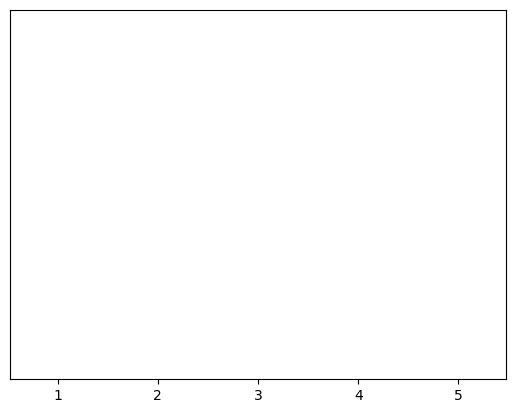

<IPython.core.display.Javascript object>

[0.78 0.22 0.   0.   0.  ]


<IPython.core.display.Javascript object>

[0.77 0.23 0.   0.   0.  ]


<IPython.core.display.Javascript object>

[0.82 0.18 0.   0.   0.  ]


<IPython.core.display.Javascript object>

[0.01 0.07 0.26 0.17 0.48]


<IPython.core.display.Javascript object>

[0.75 0.24 0.   0.   0.  ]


<IPython.core.display.Javascript object>

[0.98 0.02 0.   0.   0.  ]


<IPython.core.display.Javascript object>

[0.   0.   0.14 0.25 0.61]


<IPython.core.display.Javascript object>

[0.7  0.29 0.01 0.   0.01]


<IPython.core.display.Javascript object>

[0.09 0.24 0.25 0.08 0.35]


<IPython.core.display.Javascript object>

[0.   0.   0.15 0.44 0.42]


<IPython.core.display.Javascript object>

[0.   0.   0.12 0.44 0.44]


<IPython.core.display.Javascript object>

[0.74 0.25 0.   0.   0.  ]


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [54]:

# print-options for less clutter
np.set_printoptions(suppress=True, precision=2)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')


# load_not_train = True

if load_not_train:
    model = load_model()
    print("model loaded")
    video_interface(model, 224) # image_size
    sys.exit()


input_shape = (image_size, image_size, 3 if gray_scale else 3)

# Load datasets
prprocessed_train_len = preprocess_and_save_images('rokas_train_preprocessed', target_size=(image_size, image_size), gray_scale=gray_scale)
steps_per_epoch = prprocessed_train_len // BATCH_SIZE
print("Preprocessed train images:", prprocessed_train_len)

processed_validation_len = preprocess_and_save_images('rokas_validate_preprocessed', target_size=(image_size, image_size), gray_scale=gray_scale)
validation_steps = processed_validation_len // BATCH_SIZE
print("Preprocessed validation images:", processed_validation_len)





In [20]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: preprocessed_image_generator('rokas_train_preprocessed', batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, input_shape[0], input_shape[1], input_shape[2]), (None, 5))
)
validation_dataset = tf.data.Dataset.from_generator(
    lambda: preprocessed_image_generator('rokas_validate_preprocessed', batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, input_shape[0], input_shape[1], input_shape[2]), (None, 5))
)


184716
100/100 [==============================] - 99s 915ms/step - loss: 33.0331 - accuracy: 0.2031 - f1_score: 0.1500 - val_loss: 1.6114 - val_accuracy: 0.1813 - val_f1_score: 0.0614


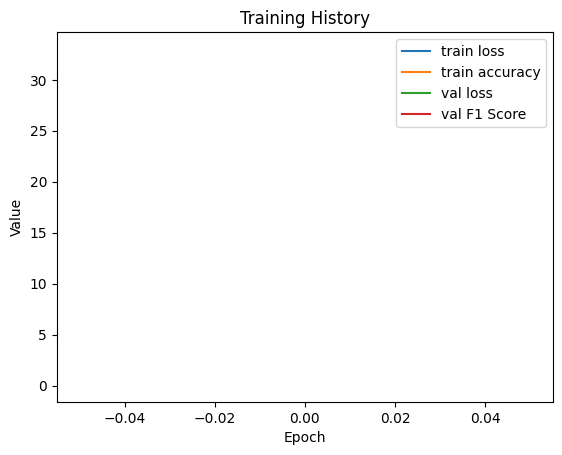

In [31]:
# model
model = create_model(input_shape)

# train
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps)

# plot the training history
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='train loss')
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='train accuracy')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val loss')
if 'val_f1_score' in history.history:
    plt.plot(history.history['val_f1_score'], label='val F1 Score')

plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

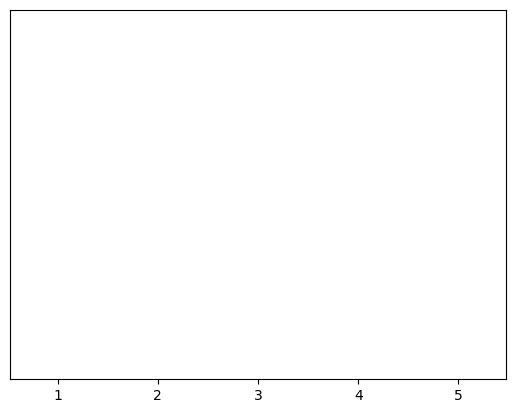

KeyboardInterrupt: 

In [32]:
# test the model using video interface aftert training
video_interface(model, image_size)